# Dropped Tarots

## Problem statement

Oops! I dropped some tarot cards into a box of pixels. Can you help me retrieve them?

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [ ]:
!curl https://storage.googleapis.com/aiolympiadmy/ioai-2025-tsp/ioai2025_tsp_selection2/dropped_tarots/dropped_tarots.npy -o dropped_tarots.npy

In [ ]:
X = np.load("dropped_tarots.npy")

In [ ]:
def visualize_pointcloud(pointcloud, elev=30, azim=30):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Extract spatial and color data
    x = pointcloud[:, 0]
    y = pointcloud[:, 1]
    z = pointcloud[:, 2]
    colors = pointcloud[:, 3:6]
    
    scatter = ax.scatter(x, y, z, c=colors, s=20)
    
    # Set axis labels and title
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    # Set view angle
    ax.view_init(elev=elev, azim=azim)
    
    # Set equal aspect ratio
    ax.set_box_aspect([1, 1, 1])
    
    plt.tight_layout()
    plt.show()

In [ ]:
visualize_pointcloud(X)

Here is how your work will be scored:

- 1 pt awarded for demonstrating every single card retrieved from the box, and plotted in notebook as individual images. All cards need to be **upright**. The card labels should be directly readeable without requiring us to tilt our heads. 
- 1 pt awarded for demonstrating every single card retrieved from the box, plotted in notebook as individual images and show that they are **perfectly upright**.
- 1 pt awarded for demonstrating every single card retrieved from the box, plotted in notebook as individual images and have them be perfectly upright and are **noise-free**.
- 2 pts awarded for reconstructing the original scene above, excluding noise. You must start from your own retrieved images that are in 2D, and arrive at a tensor with similar dimensions as the orignal `dropped_tarot.npy` albeit with different length. Capped to 1 pt only if your retrieved images are not perfectly upright and are not perfectly noise-free.
- 1 pt awarded for explaining your thought process and reasoning for your work done. Keep it brief, one short paragraph is enough!

Partial credit to be granted at discretion.

Definitions:

- Upright means:
    - the card is oriented correctly with label at the bottom, and
    - the letters of the label are in correct left to right order, and
    - the card should have <= 20 degrees rotation.
- Perfectly upright means in addition to the definition of upright above, each image should have exactly zero rotation, and thus have exactly the same dimensions as the original image. 
- No noise means each image does not contain any noise pixels, and only contains identical pixel values as the original image.

## Your work below

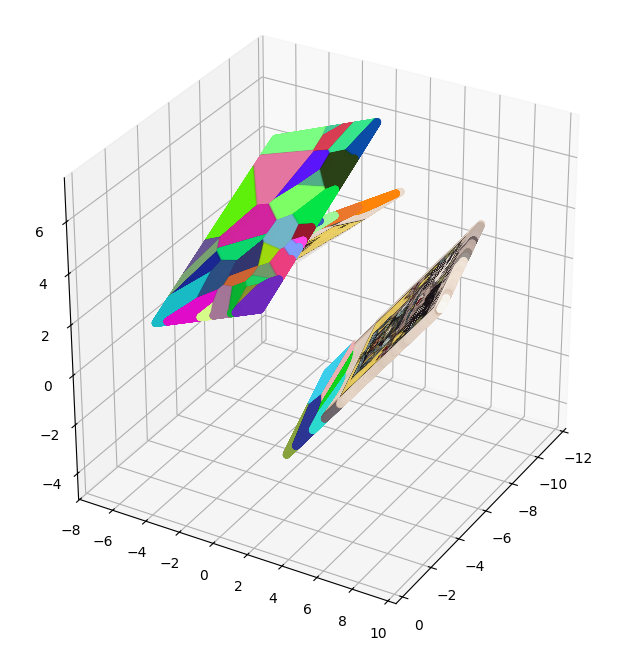

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import RANSACRegressor
from scipy.spatial import ConvexHull
import cv2
import os

# Load and visualize data
X = np.load("dropped_tarots.npy")
def visualize_pointcloud(pointcloud, elev=30, azim=30):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    x, y, z = pointcloud[:, 0], pointcloud[:, 1], pointcloud[:, 2]
    colors = pointcloud[:, 3:6]
    ax.scatter(x, y, z, c=colors, s=20)
    ax.set_box_aspect([1, 1, 1])
    ax.view_init(elev=elev, azim=azim)
    plt.show()

# Denoise by removing box
def denoise(points, colors):
    # Find bottom plane with RANSAC
    ransac = RANSACRegressor(residual_threshold=0.01, max_trials=1000)
    ransac.fit(points[:, :2], points[:, 2])
    inliers = ransac.inlier_mask_
    
    # Remove bottom and walls
    wall_margin = 0.05
    x_min, x_max = points[:, 0].min(), points[:, 0].max()
    y_min, y_max = points[:, 1].min(), points[:, 1].max()
    mask = ~inliers
    mask &= (points[:, 0] > x_min + wall_margin * (x_max - x_min))
    mask &= (points[:, 0] < x_max - wall_margin * (x_max - x_min))
    mask &= (points[:, 1] > y_min + wall_margin * (y_max - y_min))
    mask &= (points[:, 1] < y_max - wall_margin * (y_max - y_min))
    return points[mask], colors[mask]

# Process each card
def process_card(plane_points, plane_colors, idx):
    # PCA projection
    pca = PCA(n_components=2)
    projected = pca.fit_transform(plane_points)
    
    # Convex hull for bounding rectangle
    hull = ConvexHull(projected)
    hull_points = projected[hull.vertices]
    
    # Find optimal rotation
    angles = np.linspace(0, np.pi/2, 90)
    best_angle, min_area = 0, float('inf')
    for angle in angles:
        c, s = np.cos(angle), np.sin(angle)
        R = np.array([[c, -s], [s, c]])
        rotated = hull_points @ R
        bbox = rotated.max(axis=0) - rotated.min(axis=0)
        area = bbox[0] * bbox[1]
        if area < min_area:
            min_area, best_angle = area, angle
    
    # Apply rotation
    c, s = np.cos(-best_angle), np.sin(-best_angle)
    R = np.array([[c, -s], [s, c]])
    rotated_proj = projected @ R.T
    
    # Orient upright (label at bottom)
    y_min, y_max = rotated_proj[:, 1].min(), rotated_proj[:, 1].max()
    top_mask = rotated_proj[:, 1] < y_min + 0.2 * (y_max - y_min)
    bottom_mask = rotated_proj[:, 1] > y_max - 0.2 * (y_max - y_min)
    top_var = np.var(plane_colors[top_mask], axis=0).mean() if top_mask.any() else 0
    bottom_var = np.var(plane_colors[bottom_mask], axis=0).mean() if bottom_mask.any() else 0
    if top_var > bottom_var:
        rotated_proj[:, 1] = y_max + y_min - rotated_proj[:, 1]
    
    return rotated_proj, plane_colors

# Create high-res card image
def create_card_image(projected, colors, resolution=1000):
    x_min, x_max = projected[:, 0].min(), projected[:, 0].max()
    y_min, y_max = projected[:, 1].min(), projected[:, 1].max()
    
    # Create grid
    xi = np.linspace(x_min, x_max, resolution)
    yi = np.linspace(y_min, y_max, resolution)
    xx, yy = np.meshgrid(xi, yi)
    grid_coords = np.column_stack([xx.ravel(), yy.ravel()])
    
    # Nearest neighbor coloring
    tree = cKDTree(projected)
    _, indices = tree.query(grid_coords)
    grid_colors = (colors[indices] * 255).astype(np.uint8)
    image = grid_colors.reshape(resolution, resolution, 3)
    
    # Apply convex hull mask
    hull = ConvexHull(projected)
    hull_path = Path(projected[hull.vertices])
    mask = hull_path.contains_points(grid_coords).reshape(resolution, resolution)
    rgba = np.zeros((resolution, resolution, 4), dtype=np.uint8)
    rgba[..., :3] = image
    rgba[..., 3] = mask * 255
    return rgba

# Reconstruct 3D scene
def reconstruct_scene(card_data, resolution=1000):
    scene_points, scene_colors = [], []
    for (proj, colors, pca, centroid) in card_data:
        # Create grid
        x_min, x_max = proj[:, 0].min(), proj[:, 0].max()
        y_min, y_max = proj[:, 1].min(), proj[:, 1].max()
        xx, yy = np.meshgrid(
            np.linspace(x_min, x_max, resolution),
            np.linspace(y_min, y_max, resolution))
        grid_flat = np.column_stack([xx.ravel(), yy.ravel()])
        
        # Back-project to 3D
        projected_3d = pca.inverse_transform(grid_flat)
        points_3d = projected_3d + centroid
        
        # Apply colors
        tree = cKDTree(proj)
        _, indices = tree.query(grid_flat)
        colors_3d = colors[indices]
        
        scene_points.append(points_3d)
        scene_colors.append(colors_3d)
    
    return np.vstack(scene_points), np.vstack(scene_colors)

# Main processing
def main():
    points, colors = X[:, :3], X[:, 3:6]
    
    # Step 1: Denoise
    denoised_points, denoised_colors = denoise(points, colors)
    
    # Step 2: Detect card planes
    planes = []
    remaining_points, remaining_colors = denoised_points.copy(), denoised_colors.copy()
    for _ in range(3):  # Exactly 3 cards
        ransac = RANSACRegressor(residual_threshold=0.01, max_trials=1000)
        ransac.fit(remaining_points[:, :2], remaining_points[:, 2])
        inliers = ransac.inlier_mask_
        planes.append((remaining_points[inliers], remaining_colors[inliers]))
        remaining_points = remaining_points[~inliers]
        remaining_colors = remaining_colors[~inliers]
    
    # Step 3: Process and save cards
    card_data = []
    for i, (pts, clrs) in enumerate(planes):
        centroid = pts.mean(axis=0)
        pca = PCA(n_components=2).fit(pts)
        projected, colors_rot = process_card(pts, clrs, i)
        image = create_card_image(projected, colors_rot)
        plt.imsave(f"card_{i}.png", image)
        card_data.append((projected, colors_rot, pca, centroid))
    
    # Step 4: Reconstruct scene
    scene_points, scene_colors = reconstruct_scene(card_data)
    scene_cloud = np.hstack((scene_points, scene_colors))
    np.save("reconstructed_scene.npy", scene_cloud)
    visualize_pointcloud(scene_cloud)

if __name__ == "__main__":
    from scipy.spatial import cKDTree, ConvexHull
    from matplotlib.path import Path
    main()